# Optimized gauge transformation

## The goal of this notebook is to perform the gauge transformation in an optimized way inside the temporal loop so we can later move it to the GPU

### Set parametres and eviroment variables

In [19]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 2      
N = 128   
tau_sim = 1     
DTS = 8     

# Glasma fields
su_group = 'su3'
Qs = 2        
ns = 50    
factor = 0.8        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.1 * g**2 * mu         
uv = 10.0       

# TODO: Run more events
nevents = 1

In [20]:
import os

# I need to add this line to ask resources from a specific GPU, which is free. Our GPU server has no queing system
os.environ["CUDA_VISIBLE_DEVICES"]="3"

os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["PRECISION"] = "double"
os.environ['GAUGE_GROUP'] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

import curraun.su as su
import curraun.gauge_transformation as gt
# Number of colors
Nc = su.NC
# Dimension of algebra 
Dg = su.GROUP_ELEMENTS

### We define the simulation routine

In [21]:
import pickle
from tqdm import tqdm

# Simulation routine
def simulate(): 

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Plus gauge link
    uplus_LC = su.GROUP_TYPE(np.zeros((maxt//DTS-1, N, N, Dg)))
    v_LC = su.GROUP_TYPE([[[su.unit() for z in range (N)] for y in range(N)] for xplus in range (maxt//DTS)])

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):            
            # Evolve Glasma fields
            core.evolve_leapfrog(s)
            

            # Copy the necessary fields
            if t%DTS == 0 or t == 1:
                u1 = s.u1.copy()
                u0 = s.u0.copy()
                
                ux_act = u1[:,0,:].reshape(N,N,Dg)
                ux_prev = u0[:,0,:].reshape(N,N,Dg)
                
                ae_act = s.aeta1.copy().reshape(N, N, Dg)
                ae_prev = s.aeta0.copy().reshape(N, N, Dg)
                
                
                # We construct the gauge operator and transform the field
                for xplus in range(maxt//DTS):
                    for y in range(N):
                        for z  in range(N):
                            
                            v_prev = v_LC[xplus, y, z]
                            
                            if t == 1: # We initialize the gauge operator
                                v_LC[xplus, y, z] = gt.gauge_transformation_operator(ux_act[2*xplus,y], ae_act[2*xplus,y], v_prev, z, N, t)
                            
                            elif xplus > (t//DTS) and t!=0: # We construct the gauge operator
                                v_LC[xplus, y, z] = gt.gauge_transformation_operator(ux_act[2*xplus-t//DTS,y], ae_act[2*xplus-t//DTS,y], v_prev, z, N, t//DTS)
                                
                            elif xplus == (t//DTS) and t!=0: # We transform the plus links
                                uplus_LC[xplus-1, y, z] = gt.act_on_links(ux_prev[t//DTS,y], ae_prev[t//DTS,y], v_LC[xplus, y, z], v_LC[xplus-1, y, z], z, N, t//DTS)
                                
                
            
            
            pbar.update(1)

    if use_cuda:
        cuda.current_context().deallocations.clear()

    return uplus_LC

### We perform the simulation

In [22]:
# Supress various horribly long warnings
import warnings
warnings.filterwarnings('ignore')

In [23]:
uplus_LC = simulate()

Kernel xi: 0 d:  0 did not reach goal. check:  0.00023265235150697258
Kernel xi: 0 d:  1 did not reach goal. check:  0.0023943568920617073
Kernel xi: 1 d:  0 did not reach goal. check:  0.00032293338922768477
Kernel xi: 1 d:  1 did not reach goal. check:  0.0026829002998794834
Kernel xi: 2 d:  0 did not reach goal. check:  0.00040347653067575567
Kernel xi: 2 d:  1 did not reach goal. check:  0.002522462061386034
Kernel xi: 3 d:  0 did not reach goal. check:  0.0004752685850746314
Kernel xi: 3 d:  1 did not reach goal. check:  0.00208680646581845
Kernel xi: 4 d:  0 did not reach goal. check:  0.0005405256828497648
Kernel xi: 4 d:  1 did not reach goal. check:  0.0018762211720960277
Kernel xi: 5 d:  0 did not reach goal. check:  0.0005976664897181141
Kernel xi: 5 d:  1 did not reach goal. check:  0.002005404564228606
Kernel xi: 6 d:  0 did not reach goal. check:  0.000600110867860923
Kernel xi: 6 d:  1 did not reach goal. check:  0.0019393403813711344
Kernel xi: 7 d:  0 did not reach goa

Kernel xi: 1231 d:  1 did not reach goal. check:  0.0017447512524524729
Kernel xi: 1232 d:  0 did not reach goal. check:  0.00046403920117056574
Kernel xi: 1232 d:  1 did not reach goal. check:  0.0018087386279377086
Kernel xi: 1233 d:  0 did not reach goal. check:  0.00030733166426281613
Kernel xi: 1233 d:  1 did not reach goal. check:  0.0017125564458740279
Kernel xi: 1234 d:  0 did not reach goal. check:  0.0002084531636761615
Kernel xi: 1234 d:  1 did not reach goal. check:  0.0016464308636947567
Kernel xi: 1235 d:  0 did not reach goal. check:  0.0001749027003105537
Kernel xi: 1235 d:  1 did not reach goal. check:  0.0011607217283715503
Kernel xi: 1236 d:  0 did not reach goal. check:  0.0001916400223837441
Kernel xi: 1236 d:  1 did not reach goal. check:  0.0005549914198698363
Kernel xi: 1237 d:  0 did not reach goal. check:  0.00022106568152481428
Kernel xi: 1237 d:  1 did not reach goal. check:  0.00033755689957803124
Kernel xi: 1238 d:  0 did not reach goal. check:  0.00023003

100%|██████████| 512/512 [02:30<00:00,  3.41it/s]


### We make some plots to check the shape of the transformed fields

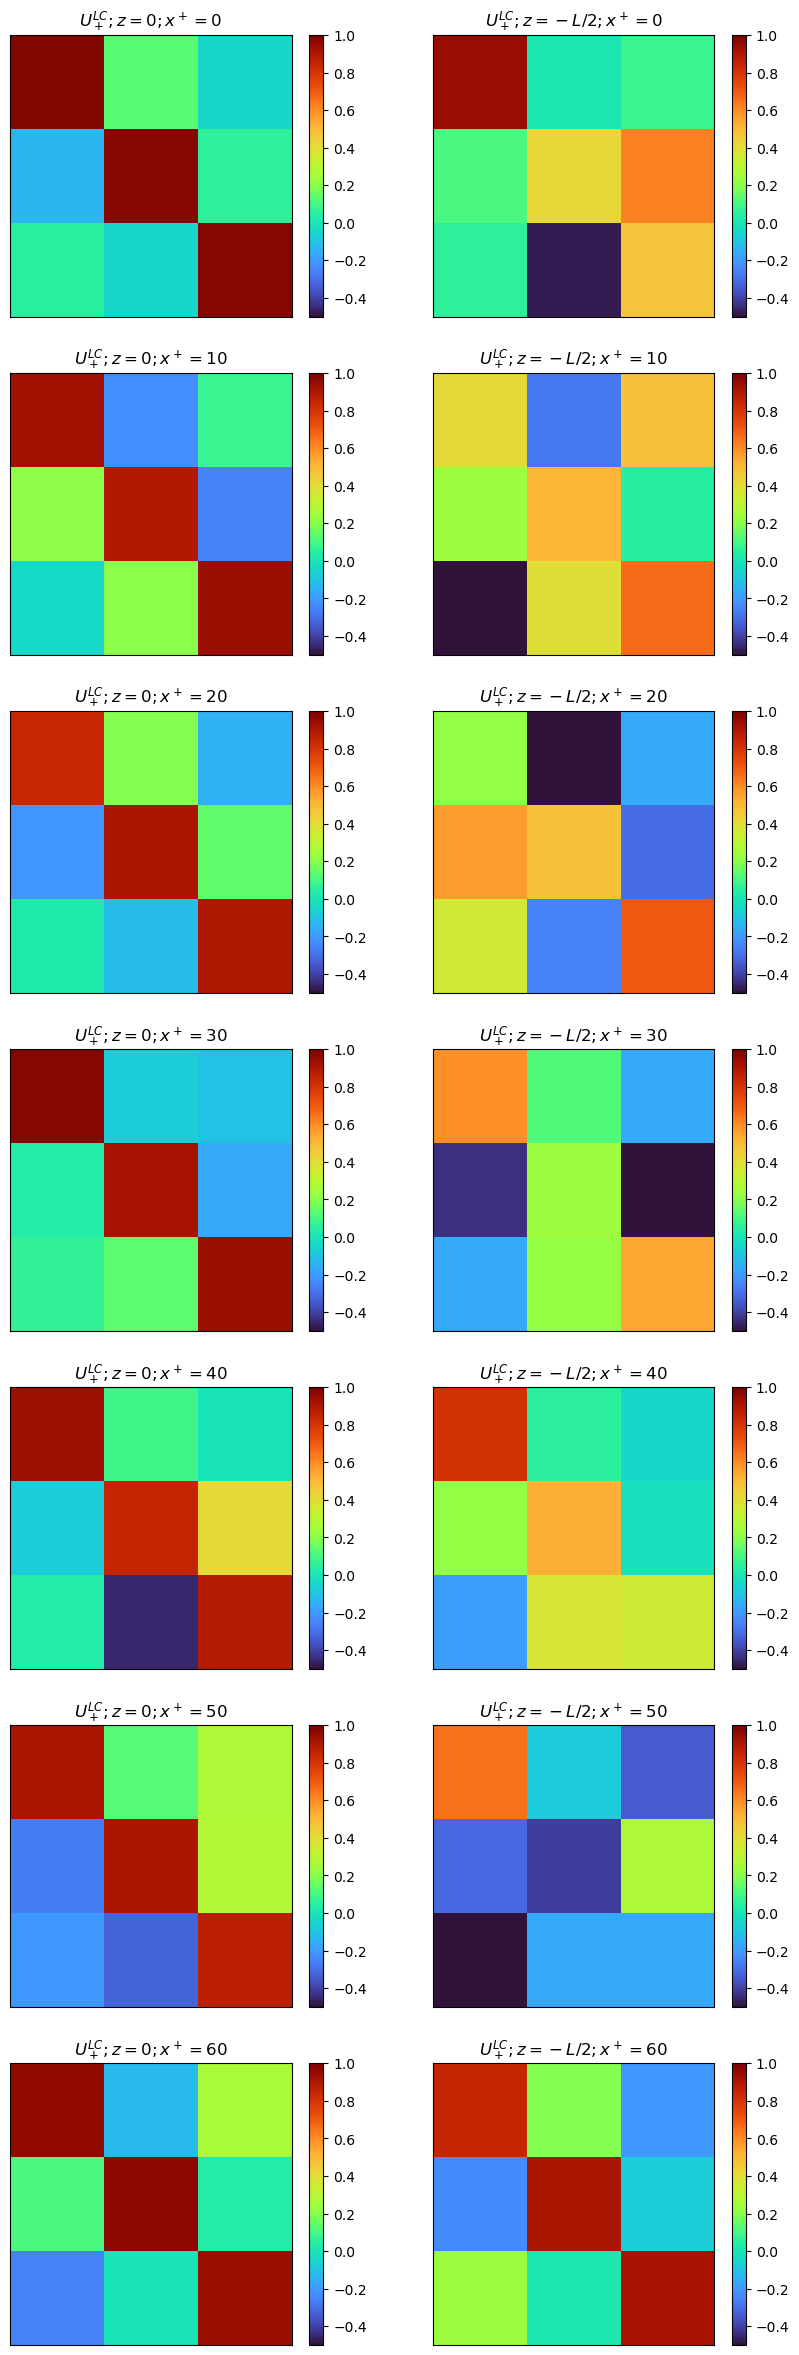

In [24]:
import matplotlib.pyplot as plt 

# We plot the matrix elements of the btransformed fields at central and extreme values of z

t_steps = int(tau_sim*N / L)
y = N//2

uplus_LC_plot = uplus_LC.reshape(t_steps-1, N, N, 3, 3)

fig, axs = plt.subplots(t_steps//10 +1, 2, figsize=(10,30))

for t in range(t_steps//10 + 1): 
    tau = 10*t
    plot1 = axs[t,0].imshow(uplus_LC_plot[tau, y, N//2, :, :].real, cmap='turbo', vmin=-0.5, vmax=1) 
    axs[t,0].set_title(r'$U_+^{LC}; z =0; x^+ = %i $' %tau)
    plt.colorbar(plot1, ax = axs[t,0])
    axs[t,0].axes.get_xaxis().set_visible(False)
    axs[t,0].axes.get_yaxis().set_visible(False)
    
    plot1 = axs[t, 1].imshow(uplus_LC_plot[tau, y, 0, :, :].real, cmap='turbo', vmin=-0.5, vmax=1)
    axs[t,1].set_title(r'$U_+^{LC}; z = -L/2; x^+ = %i $' %tau)
    plt.colorbar(plot1, ax = axs[t,1])
    axs[t,1].axes.get_xaxis().set_visible(False)
    axs[t,1].axes.get_yaxis().set_visible(False)

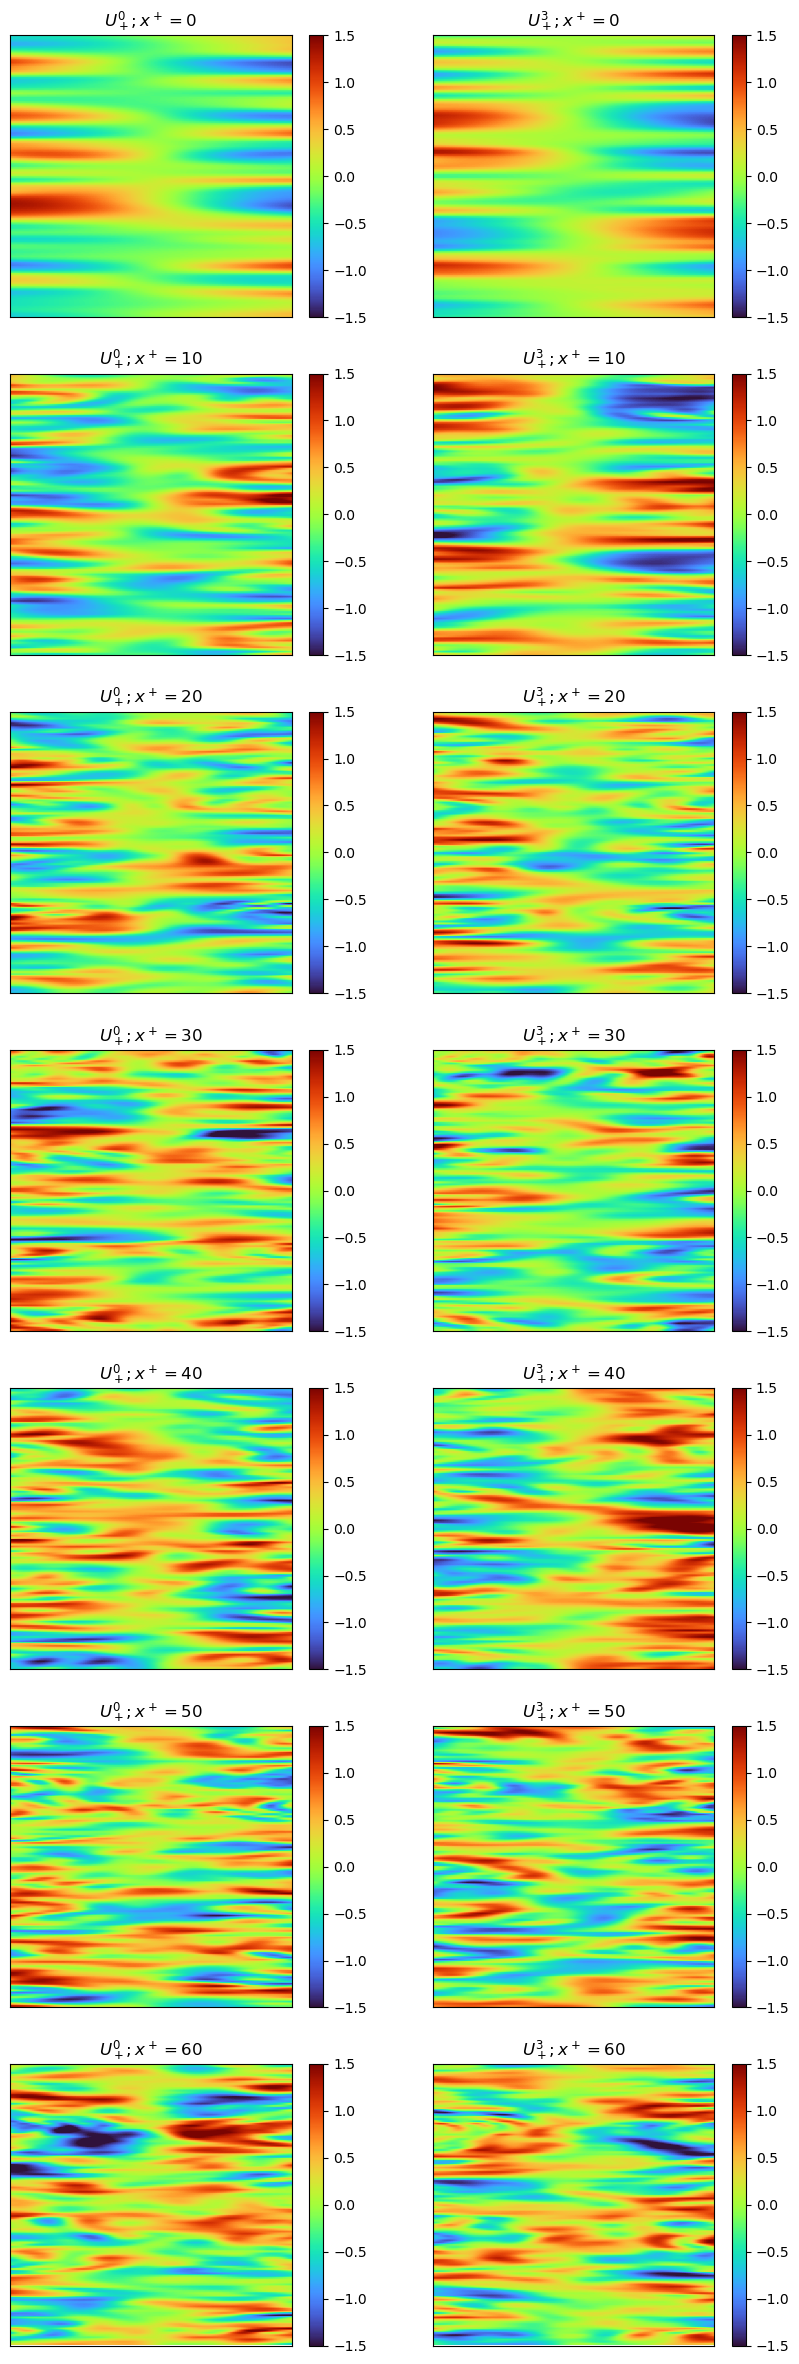

In [25]:
# We a color component of the transformed field in the transverse plane
u_comp = np.apply_along_axis(su.get_algebra_factors_from_group_element_approximate, 3, uplus_LC)

fig, axs = plt.subplots(t_steps//10 +1, 2, figsize=(10,30))

for t in range(t_steps//10 + 1): 
    tau = 10*t
    plot1 = axs[t,0].imshow(u_comp[tau, :, :, 0].real, cmap='turbo', vmin=-1.5, vmax=1.5) 
    axs[t,0].set_title(r'$U_+^{0}; x^+ = %i $' %tau)
    plt.colorbar(plot1, ax = axs[t,0])
    axs[t,0].axes.get_xaxis().set_visible(False)
    axs[t,0].axes.get_yaxis().set_visible(False)
    
    plot1 = axs[t, 1].imshow(u_comp[tau, :, :, 3].real, cmap='turbo', vmin=-1.5, vmax=1.5)
    axs[t,1].set_title(r'$U_+^{3}; x^+ = %i $' %tau)
    plt.colorbar(plot1, ax = axs[t,1])
    axs[t,1].axes.get_xaxis().set_visible(False)
    axs[t,1].axes.get_yaxis().set_visible(False)

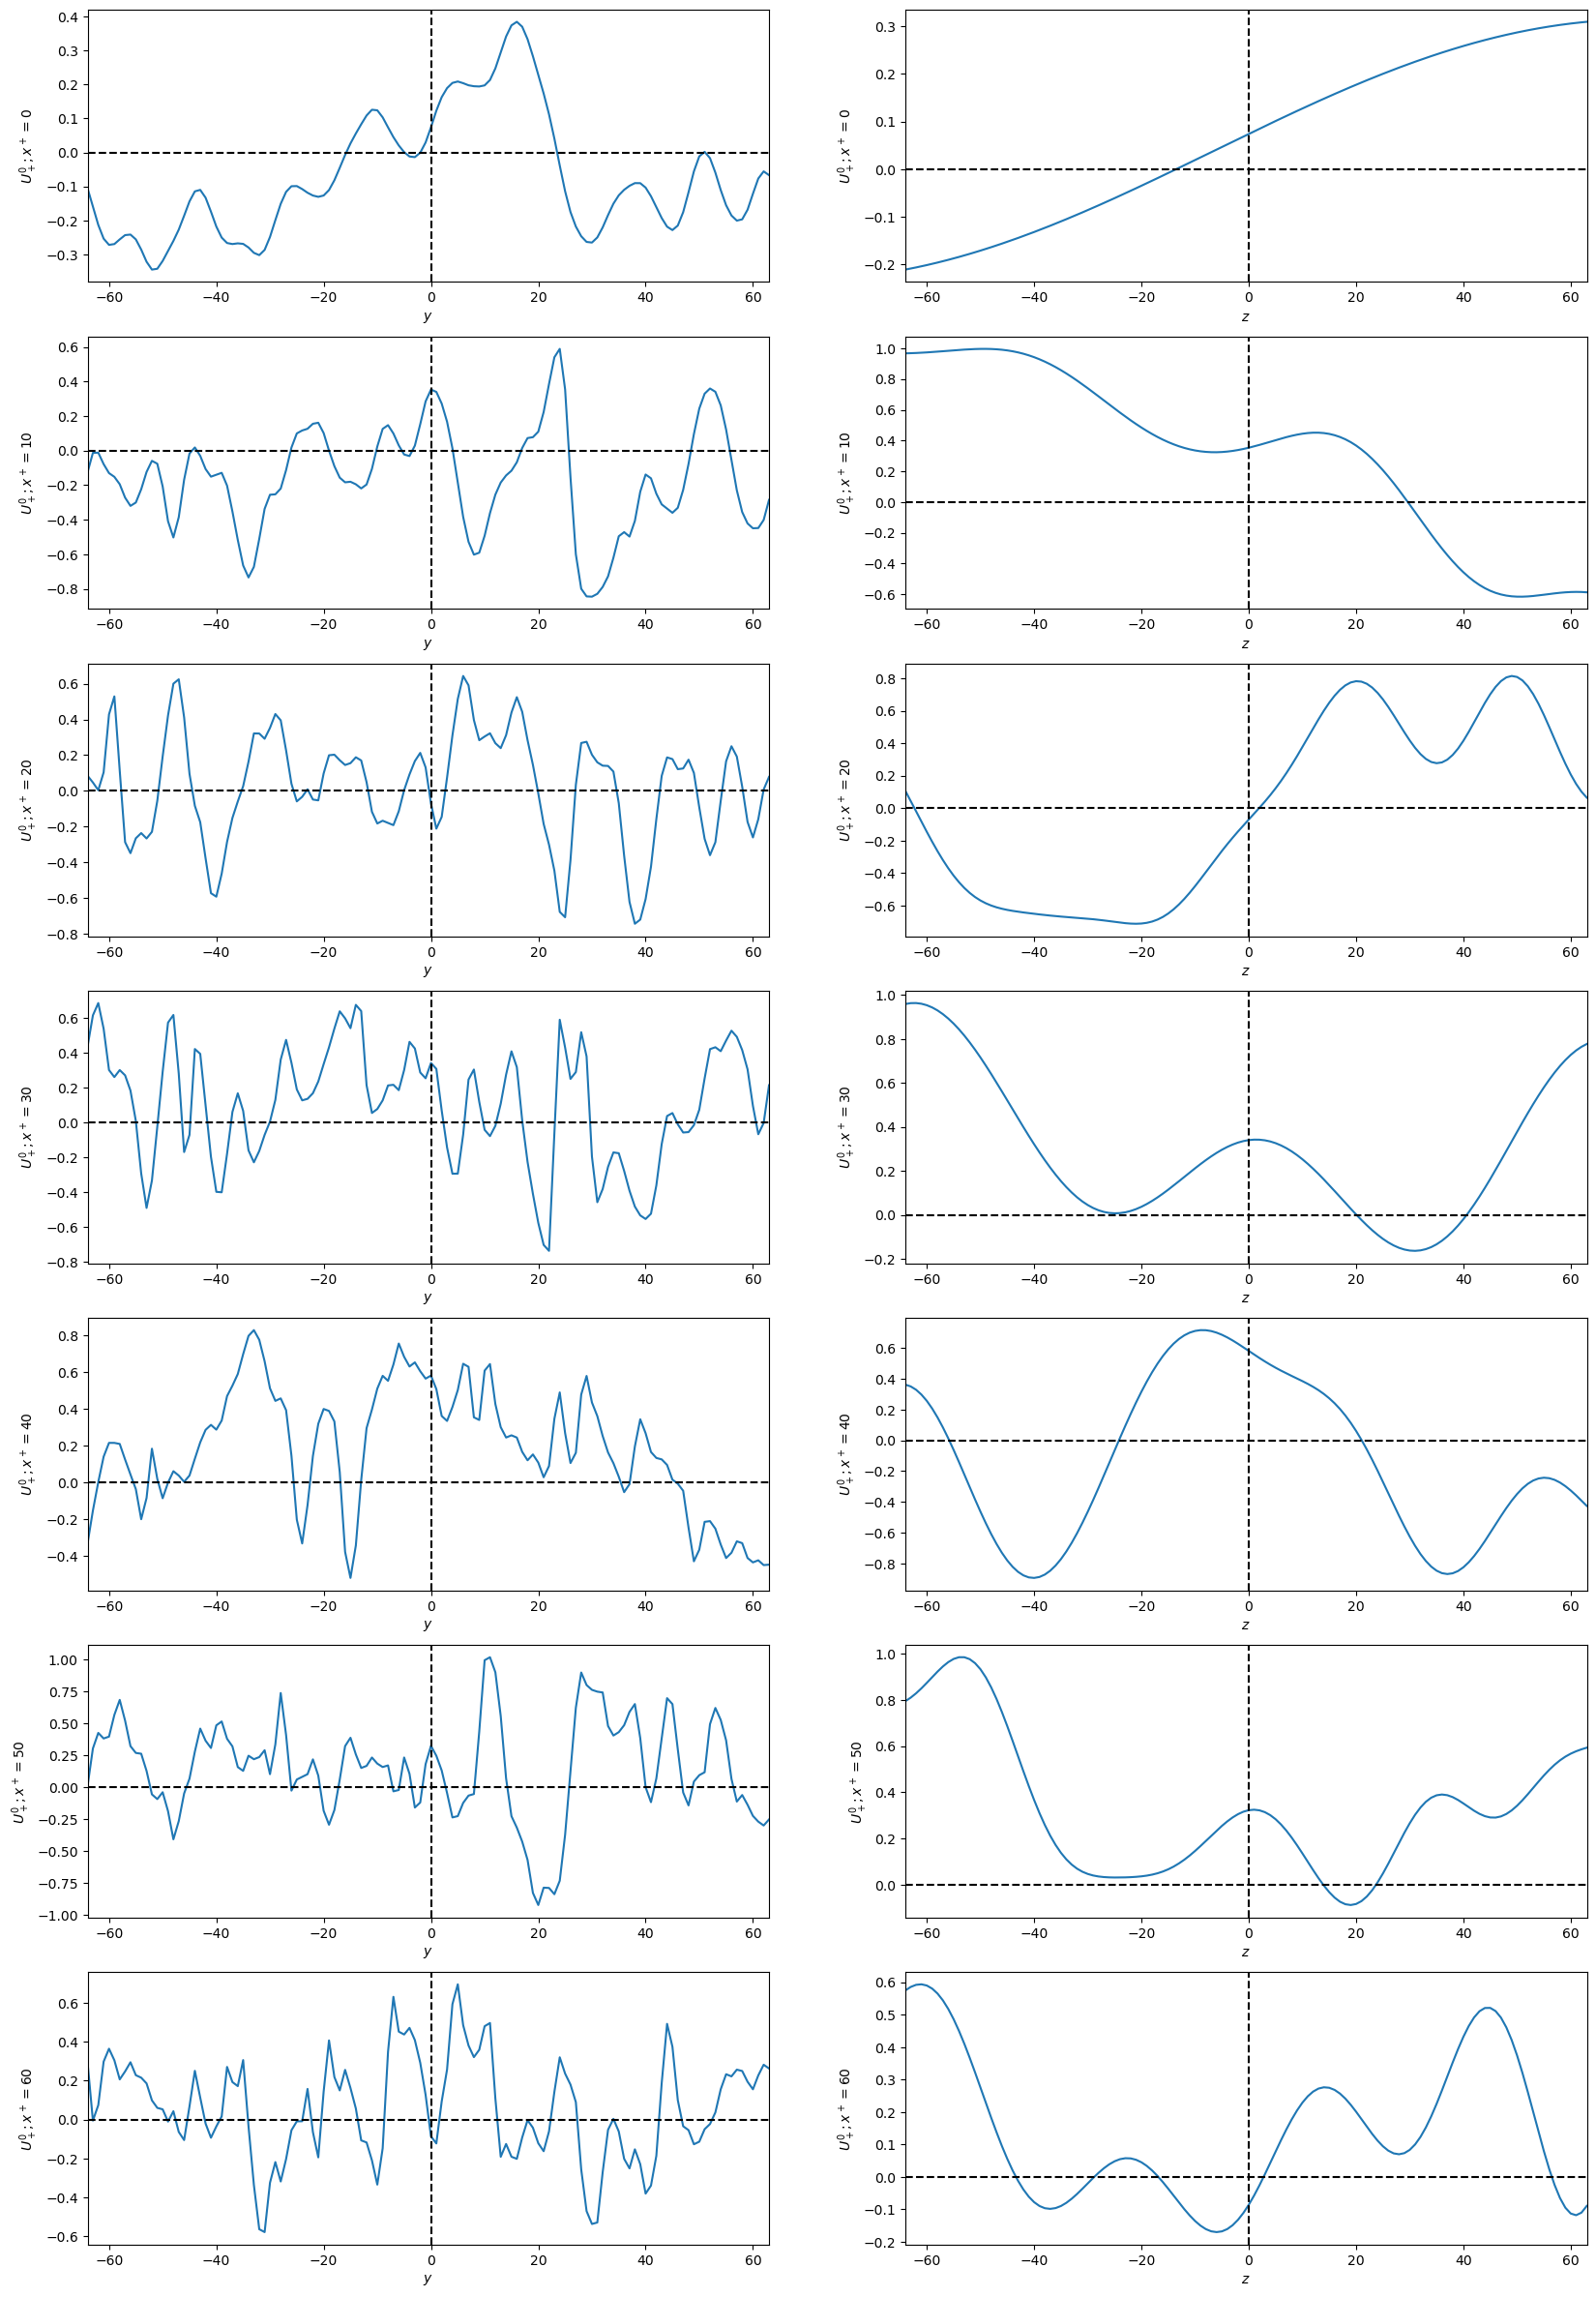

In [26]:
# We plot the links for a single color component as a function of y and as a function of z

fig, axs = plt.subplots(t_steps//10 +1, 2, figsize=(20,30))
aux = np.linspace(0,127, 128)

for t in range(t_steps//10 + 1): 
    tau = 10*t
    plot1 = axs[t,0].plot(aux-N//2, u_comp[tau, :, N//2, 0].real) 
    axs[t,0].hlines(0, -64, 63, colors="black", linestyle='dashed')
    ymin, ymax = axs[t,0].get_ylim()
    axs[t,0].vlines(0, ymin, ymax, colors='black', linestyle='dashed')
    axs[t,0].set_xlabel(r'$y$')
    axs[t,0].set_ylabel(r'$U_+^{0}; x^+ = %i $' %tau)
    axs[t,0].set_xlim(-64, 63)
    axs[t,0].set_ylim(ymin, ymax)
    
    plot2 = axs[t,1].plot(aux-N//2, u_comp[tau, N//2, :, 0].real)
    axs[t,1].hlines(0, -64, 63, colors="black", linestyle='dashed')
    ymin, ymax = axs[t,1].get_ylim()
    axs[t,1].vlines(0, ymin, ymax, colors='black', linestyle='dashed')
    axs[t,1].set_xlabel(r'$z$')
    axs[t,1].set_ylabel(r'$U_+^{0}; x^+ = %i $' %tau)
    axs[t,1].set_xlim(-64, 63)
    axs[t,1].set_ylim(ymin, ymax)

- - -
Write the outputs to files. First, the numerical Glasma parameters in `glasma_parameters.txt`.

In [27]:
# Save relevant parameters to text file
param_names = ["L [fm]", "N", "a [fm]", "tau_sim [fm/c]", "tau_steps"]
# The last time step in x^+ in skipped, so only N/2-1 time steps
# The lattice discretization in z coincides with the one in y
param_values = [L, N, L/N, tau_sim, int(N/2)-1]

# output_file = open("glasma_parameters_v2.txt", "a")
output_file = open("glasma_parameters.txt", "a")
for p in range(len(param_names)):
    output_file.write(param_names[p] + " " + str(param_values[p]) + "\n")
output_file.close()

In [28]:
# Save relevant parameters to text file
param_names = ["L_perp [GeV^-1]", "N_perp", "time_tot [GeV^-1]", "time_step"]
# The last time step in x^+ in skipped, so only N/2-1 time steps
# The lattice discretization in z coincides with the one in y
param_values = [L/2/hbarc, round(N/2), tau_sim*np.sqrt(2)/hbarc, int(N/2)-1]

# output_file = open("glasma_parameters_v2.txt", "a")
output_file = open("glasma_parameters_qjetlfh_input.txt", "a")
for p in range(len(param_names)):
    output_file.write(param_names[p] + " " + str(param_values[p]) + "\n")
output_file.close()

Second, the transformed gauge link $U_+ (x^+, y, z)$ as a `numpy` array in `uplus_glasma.npy`.

In [29]:
np.save('uplus_glasma_v2.npy', uplus_LC)

In [30]:
# I use this values to test that reading the numpy array in C++ is correct
uplus_LC[10, 12, 10, :]

array([ 0.53989075+0.56241178j, -0.55276919+0.04226602j,
       -0.04508108+0.28781673j,  0.40830094-0.41220644j,
        0.03462986-0.78023119j, -0.10954871+0.20350754j,
       -0.17104874+0.16226361j,  0.27383264-0.0878382j ,
        0.66578141+0.64687564j])

- - -
Read the input file `uplus_glasma.npy` sent to Meijian.

In [31]:
uplus_file = np.load('uplus_glasma.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'uplus_glasma.npy'

Output a time slice, let's choose $x^+_\mathrm{lattice}=10$, the (y,z) dependence, in a `*.txt` file, for Meijian.

In [ ]:
# Output each color components in a different file, as a yz array

folder_path = "uplus_glasma_xplus_10_color/"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

for c in range(Dg):
    output_file = open(folder_path + "c_" + str(c) + ".txt", "a")
    for y in range(N):
        for z in range(N):
            output_file.write(str(uplus_file[10, y, z, c]) + " ")
            if z==(N-1):
                output_file.write(str(uplus_file[10, y, z, c]) + "\n")
output_file.close()

In [ ]:
folder_path = "uplus_glasma_xplus_10_coord/"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Output all color components for each yz pair in a different file
for y in range(N):
    for z in range(N):
        output_file = open(folder_path + "y_" + str(y) + "_z_" + str(z) + ".txt", "a")
        for c in range(Dg):
            output_file.write(str(uplus_file[10, y, z, c]) + "\n")
output_file.close()